In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import os
from sklearn.linear_model import LinearRegression

In [47]:
# Load data
datapath = os.path.join("data", "mosquito_data_part_2.csv")
mosquito_data = pd.read_csv(datapath)
mosquito_data.head(7)

,Year,Week,Address Block,Trap,Trap type,Date,Mosquito number,WNV Present,Species,Lat,Lon,Month
0,2019,39,100XX W OHARE AIRPORT,T910,GRAVID,2019-09-26 00:09:00,2,negative,CULEX RESTUANS,41.977738,-87.880969,9
1,2019,39,52XX S KOLMAR AVE,T114,GRAVID,2019-09-26 00:09:00,1,negative,CULEX RESTUANS,41.798211,-87.736925,9
2,2019,39,58XX N WESTERN AVE,T028,GRAVID,2019-09-26 00:09:00,2,negative,CULEX RESTUANS,41.987245,-87.689417,9
3,2019,39,39XX N SPRINGFIELD AVE,T228,GRAVID,2019-09-26 00:09:00,1,negative,CULEX RESTUANS,41.953664,-87.724987,9
4,2019,39,131XX S BRANDON AVE,T209,GRAVID,2019-09-26 00:09:00,9,negative,CULEX RESTUANS,41.657069,-87.546049,9
5,2019,39,21XX N CANNON DR,T054C,GRAVID,2019-09-26 00:09:00,2,negative,CULEX RESTUANS,41.921777,-87.632140,9
6,2019,39,11XX W ROOSEVELT RD,T048,GRAVID,2019-09-26 00:09:00,3,negative,CULEX RESTUANS,41.866915,-87.654919,9


In [48]:
print(f"The data has {mosquito_data.shape[0]} rows and {mosquito_data.shape[1]} columns.")
mosquito_data.info() # Check for missing values and column data types

The data has 18495 rows and 12 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18495 entries, 0 to 18494
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             18495 non-null  int64  
 1   Week             18495 non-null  int64  
 2   Address Block    18495 non-null  object 
 3   Trap             18495 non-null  object 
 4   Trap type        18495 non-null  object 
 5   Date             18495 non-null  object 
 6   Mosquito number  18495 non-null  int64  
 7   WNV Present      18495 non-null  object 
 8   Species          18495 non-null  object 
 9   Lat              18495 non-null  float64
 10  Lon              18495 non-null  float64
 11  Month            18495 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 1.7+ MB


The data has no missing values and all columns have the correct data types.

In [49]:
# Check for duplicates
mosquito_data.duplicated().sum()
print(f"There are {mosquito_data.duplicated().sum()} duplicates. In this case, I will remove the last occurance of each duplicate.")

There are 658 duplicates. In this case, I will remove the last occurance of each duplicate.


In [50]:
# removing the last occurance of each duplicate
mosquito_data.drop_duplicates(keep= "first", inplace = True)
print(f"After removing the last occurance of each duplicate, the data has {mosquito_data.duplicated().sum()} duplicates.")

After removing the last occurance of each duplicate, the data has 0 duplicates.


In [51]:
# basic descriptive statistics
mosquito_data.describe(exclude="object")

,Year,Week,Mosquito number,Lat,Lon,Month
count,17837.000000,17837.000000,17837.000000,17837.000000,17837.000000,17837.000000
mean,2012.850591,30.979088,10.458822,41.848969,-87.707359,7.621741
std,3.733999,4.377505,13.182843,0.114807,0.091859,1.006730
min,2007.000000,20.000000,1.000000,41.644720,-87.880969,5.000000
25%,2010.000000,28.000000,2.000000,41.746732,-87.770837,7.000000
50%,2013.000000,31.000000,4.000000,41.867599,-87.700238,8.000000
75%,2016.000000,34.000000,13.000000,41.962021,-87.643076,8.000000
max,2019.000000,40.000000,50.000000,42.017801,-87.531051,10.000000


Key takeaways:
- The data was collected from 2007 to 2019, from week 20 to week 40 (The month column above shows that it was from May to October).
- The minimum number of mosquitoes collected was 1 per trap, max was 50 with an average of 10.5 mosquitoes per trap.

In [52]:
mosquito_data.columns

Index(['Year', 'Week', 'Address Block', 'Trap', 'Trap type', 'Date',
       'Mosquito number', 'WNV Present', 'Species', 'Lat', 'Lon', 'Month'],
      dtype='object')

In [53]:
# Converting WNV Present to binary
mosquito_data['WNV Present'] = mosquito_data['WNV Present'].map({'negative': 0, 'positive': 1})

# Creating dummy variables for Trap type
mosquito_data = pd.get_dummies(mosquito_data, columns=['Trap type'], drop_first=True) 
#drop_first drops the CDC trap type and makes it the reference category

# Average number of moquitoes per month
mosquito_data.groupby('Month')['Mosquito number'].mean()

Month
5      2.761905
6     10.039783
7     11.053295
8     11.605926
9      8.156741
10     5.377778
Name: Mosquito number, dtype: float64

Takeaways:
- May had the minimum number of mosquitoes and August had the maximum number of mosquitoes on average
- The number of mosquitoes collected per month increased as the weather got hotter (May-August) and decreased in the fall season(September - October)

#### Investigating statistical difference between mosquito species by WNV Occurrence. 
We will use t-test to compare mosquito species by WNV Present

- Null Hypothesis, $H_{0}$: THe mean of WNV occurrence is the same for all mosquito species
- Alternative Hypothesis, $H_{a}$: The mean of WNV occurrence is different for different mosquito species



# COME BACK LATER...

<AxesSubplot:>

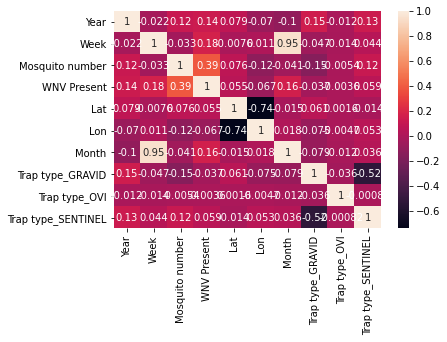

In [58]:
# Investigating the correlation between the variables
mosquito_data.corr()
# heatmap of the correlation between the variables
sns.heatmap(mosquito_data.corr(), annot=True)

Observations:
- The number of mosquitoes is positively correlated with WNV present (corr = 0.39)
- There is a slight positive correlation between the number of mosquitoes and Year, Lat, and SENTINEL trap type. 
- Mosquito number is negatively correlated with Week, Long, Month, other trap types (GRAVID, OVI)

Let's investigate if these correlation are statistically significant.

In [83]:
# Checking the significance of negative correlations with mosquito number
correlations = ['Week', 'Lon', 'Month', 'Trap type_GRAVID', 'Trap type_OVI', 'WNV Present', 'Year', 'Lat', 'Trap type_SENTINEL']

for i in correlations:
    mosqnumber_i = stats.pearsonr(mosquito_data['Mosquito number'], mosquito_data[i])
    print(f"The correlation between Mosquito number and {i} is {mosqnumber_i[0]:.2f} with a p-value of {mosqnumber_i[1]:.2f}. This means the correlation is {'statistically significant' if mosqnumber_i[1]< 0.05 else 'not statistically significant'}.")

The correlation between Mosquito number and Week is -0.03 with a p-value of 0.00. This means the correlation is statistically significant.
The correlation between Mosquito number and Lon is -0.12 with a p-value of 0.00. This means the correlation is statistically significant.
The correlation between Mosquito number and Month is -0.04 with a p-value of 0.00. This means the correlation is statistically significant.
The correlation between Mosquito number and Trap type_GRAVID is -0.15 with a p-value of 0.00. This means the correlation is statistically significant.
The correlation between Mosquito number and Trap type_OVI is -0.01 with a p-value of 0.47. This means the correlation is not statistically significant.
The correlation between Mosquito number and WNV Present is 0.39 with a p-value of 0.00. This means the correlation is statistically significant.
The correlation between Mosquito number and Year is 0.12 with a p-value of 0.00. This means the correlation is statistically significan

# USE VARIABLES THAT HAVE A STATISTICALLY SIGNIFICANT CORRELATION WITH MOSQUITO NUMBER

In [92]:
# Defining dependent and independent variables
X = mosquito_data[['Week', 'Lon', 'Month', 'Trap type_GRAVID', 'Trap type_OVI', 'WNV Present', 'Year', 'Lat', 'Trap type_SENTINEL']].values.reshape(-1,9)
y = mosquito_data['Mosquito number'].values.reshape(-1,1)

In [97]:
regressor = LinearRegression()
regressor.fit(X, y)

LinearRegression()

In [91]:
X

array([[ 3.90000000e+01, -8.78809690e+01,  9.00000000e+00, ...,
         2.01900000e+03,  4.19777376e+01,  0.00000000e+00],
       [ 3.90000000e+01, -8.77369250e+01,  9.00000000e+00, ...,
         2.01900000e+03,  4.17982107e+01,  0.00000000e+00],
       [ 3.90000000e+01, -8.76894168e+01,  9.00000000e+00, ...,
         2.01900000e+03,  4.19872446e+01,  0.00000000e+00],
       ...,
       [ 3.40000000e+01, -8.77584030e+01,  8.00000000e+00, ...,
         2.00700000e+03,  4.19653759e+01,  0.00000000e+00],
       [ 3.00000000e+01, -8.75901758e+01,  7.00000000e+00, ...,
         2.01600000e+03,  4.16623951e+01,  0.00000000e+00],
       [ 3.30000000e+01, -8.76647583e+01,  8.00000000e+00, ...,
         2.01700000e+03,  4.19191971e+01,  1.00000000e+00]])